In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import tracemalloc
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates,
    PIMultipleDates,
    MOMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble, ManagerEvidential2
from src.Logger import Logger
import src.rasterTools as rasterTools



Tensorflow ver. 2.6.0


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "MS", # values: MT, PA, MS, PI
	"training_date": "earlier", # values: earlier, current
	"mode": "ensemble", # values: mcd, single_run, ensemble, evidential2
	"uncertainty_method": "pred_entropy", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,
	"learning_rate": 1e-4,
    "use_cloud_mask": False,
    "mask_out_non_biome": False
	# "mask_out_no_data": True
}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
elif config['mode'] == 'evidential2':
	managerClass = ManagerEvidential2
	config['inference_times'] = 1
	config['training_times'] = 1
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]
	datasetClass = PAMultipleDates
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MTMultipleDates
elif config['site'] == 'MS':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2019, 2020]

	else:
		dates = [2019, 2020]
		# dates = [2020, 2021]

	datasetClass = MSMultipleDates
elif config['site'] == 'PI':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2017, 2018]

	else:
		dates = [2019, 2020]
		# dates = [2018, 2019]

	datasetClass = PIMultipleDates
	config['mask_out_non_biome'] = True
elif config['site'] == 'MO':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MOMultipleDates

else:
	raise ValueError('Invalid site')

dataset = datasetClass(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 1; repetition_id = 7
			exp = 20; repetition_id = 0
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 4; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			# exp = 5; repetition_id = 0		
			# exp = 24; repetition_id = 0	
			# exp = 30; repetition_id = 0	# L1C
			exp = 37; repetition_id = 0	# L1C (New)
			
	elif type(dataset) == PIMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			## exp = 18; repetition_id = 0	
			exp = 27; repetition_id = 0 # L1C
			# exp = 28; repetition_id = 0 # L1C 2020
	elif type(dataset) == MOMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			exp = 19; repetition_id = 0	

else:

	exp = 37
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'MS', 'training_date': 'earlier', 'mode': 'ensemble', 'uncertainty_method': 'pred_entropy', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': False, 'mask_out_non_biome': False, 'inference_times': 10, 'training_times': 10}


ic| dataset.py:540 in __init__()- list(self.date_ids): [0]
ic| dataset.py:561 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8]]
ic| patchesHandler.py:166 in __init__()- self.input_image_shape: 9
ic| patchesHandler.py:167 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8]]


In [8]:
'''
import src.Logger as lg
importlib.reload(lg)
logger = Logger()
manager.logger = logger
'''

'\nimport src.Logger as lg\nimportlib.reload(lg)\nlogger = Logger()\nmanager.logger = logger\n'

In [9]:
dates

[2019, 2020]

In [10]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'MS',
 'training_date': 'earlier',
 'mode': 'ensemble',
 'uncertainty_method': 'pred_entropy',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': False,
 'mask_out_non_biome': False,
 'inference_times': 10,
 'training_times': 10,
 'dropout_training': False}

In [11]:
exp

37

In [12]:
manager.setExperimentPath()
manager.createLogFolders()

In [13]:
# ic(type(dataset), exp, dataset.dates)


In [14]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/MS/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:638 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:641 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:645 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MS/deforestation_before_2000_MS.tif


ic| dataset.py:649 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 208], dtype=uint8), array([126708038, 235735967], dtype=int64))
ic| dataset.py:651 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))
ic| dataset.py:630 in loadLabel()
    label_per_date.shape: (18605, 19481, 1)


Removing bufer................
Mask label shape:  
 (18605, 19481, 1) 
 Unique values:  
 [0 1 2]


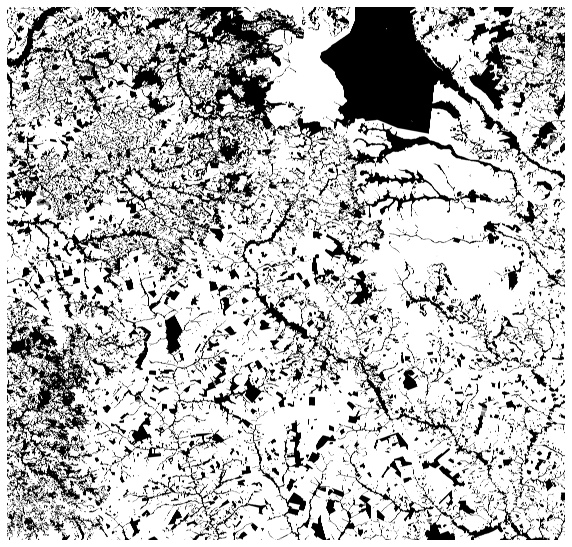

In [15]:
manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [16]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3721 3896
Mask size:  (18605, 19480)


In [17]:
def get_pixel_count_set(label, mask, set_id):
    label_set = label[mask == set_id]
    return np.unique(label_set, return_counts=True)


In [18]:

np.unique(manager.mask_tiles)
for set_id in np.unique(manager.mask_tiles):
    print('Set', set_id, get_pixel_count_set(manager.label_mask, manager.mask_tiles, set_id))


Set 1 (array([0, 1, 2], dtype=uint8), array([4870897,  107548, 9518571], dtype=int64))
Set 2 (array([0, 1, 2], dtype=uint8), array([5863739,   42735, 8590542], dtype=int64))
Set 3 (array([0, 1, 2], dtype=uint8), array([5043217,     380, 9453419], dtype=int64))
Set 4 (array([0, 1, 2], dtype=uint8), array([11586786,      524,  2909706], dtype=int64))
Set 5 (array([0, 1, 2], dtype=uint8), array([5102453,    8953, 9385610], dtype=int64))
Set 6 (array([0, 1, 2], dtype=uint8), array([ 4079965,    73003, 10344048], dtype=int64))
Set 7 (array([0, 1, 2], dtype=uint8), array([4678683,   19973, 9798360], dtype=int64))
Set 8 (array([0, 1, 2], dtype=uint8), array([ 3810754,    20163, 10666099], dtype=int64))
Set 9 (array([0, 1, 2], dtype=uint8), array([ 4360787,     7117, 10129112], dtype=int64))
Set 10 (array([0, 1, 2], dtype=uint8), array([ 2962032,    40216, 11494768], dtype=int64))
Set 11 (array([0, 1, 2], dtype=uint8), array([ 3461781,    13658, 11021577], dtype=int64))
Set 12 (array([0, 1, 2]

In [19]:

manager.label_mask.dtype

dtype('uint8')

In [20]:

manager.getLabelCurrentDeforestation()

In [21]:

manager.loadInputImage()

ic| dataset.py:581 in loadInputImage()
    image_stack.shape: (18605, 19481, 9)


Image shape:  (18605, 19481, 9)
mask:  (18605, 19480)
image stack:  (18605, 19480, 9)
ref : (18605, 19480, 1)


In [22]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [5, 6, 7]]

In [23]:
condition = np.squeeze(np.zeros_like(manager.label_mask))


In [24]:
condition.shape

(18605, 19480)

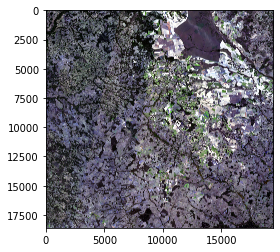

In [25]:
plt.imshow(manager.image_stack[...,[3,2,1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


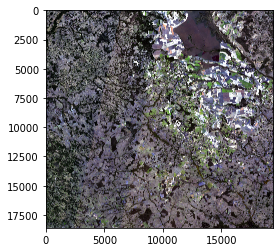

In [26]:
plt.imshow(manager.image_stack[...,[7,6,5]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


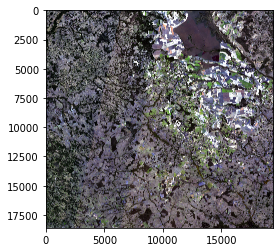

In [27]:
plt.imshow(manager.image_stack[...,[7,6,5]])

In [28]:
# condition=np.all(
#     np.squeeze(manager.image_stack[...,[7,6,5]]) == 0, axis=-1)


In [29]:
# np.unique(condition, return_counts=True)

In [30]:
# plt.imshow(condition, cmap='gray')

In [31]:

# condition = manager.image_stack[...,[4,3,2,1]] == 0 and manager.image_stack[...,[8,7,6,5]] == 0

In [32]:
# condition.shape

In [33]:
# plt im show condition

# manager.logger.plotFigure(condition, 
#     name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [34]:
# mask out no data


# manager.label_mask[condition == 1] = 2

In [35]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.05263158, 0.10526316, 0.15789473, 0.21052632,
        0.2631579 , 0.31578946, 0.36842105, 0.42105263, 0.5263158 ,
        0.6315789 , 0.7368421 , 0.84210527, 0.94736844, 1.        ],
       dtype=float32),
 array([ 99662188,    560438,    316161,    440417,    310884,    701575,
           318766,    903906,   1003651,   1305903,   2096238,   3824633,
          6540581,   8716969, 235723090], dtype=int64))

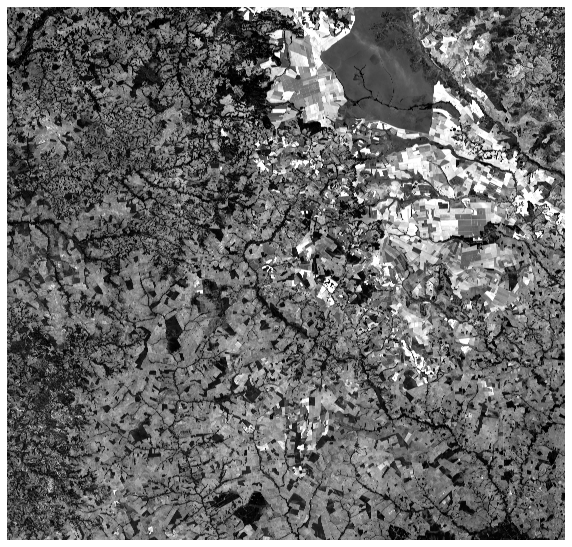

In [36]:

manager.logger.plotFigure(manager.image_stack[...,1], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

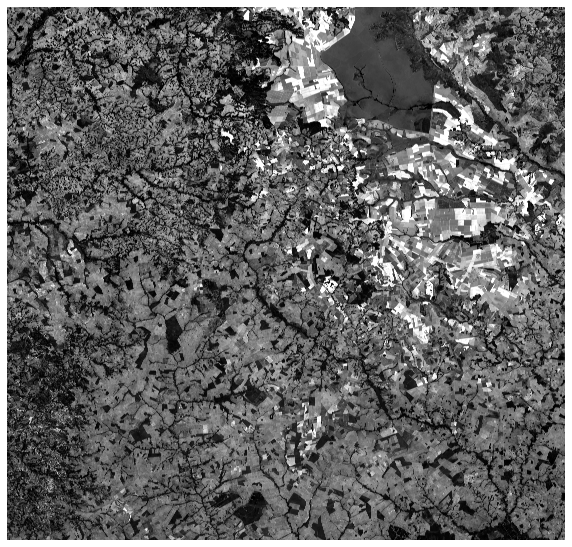

In [37]:

manager.logger.plotFigure(manager.image_stack[...,5], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [38]:
np.unique(manager.label_mask, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([ 99008239,    506597, 262910564], dtype=int64))

In [39]:
# manager.maskNoDataAsNotConsideredClass()

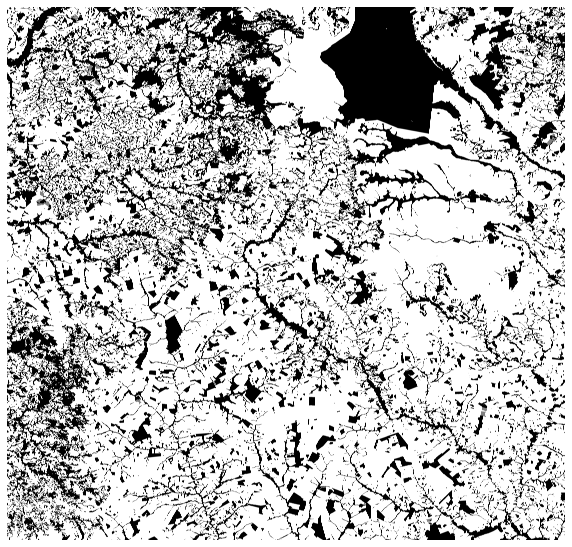

In [40]:

manager.logger.plotFigure(manager.label_mask, 
    name='label_mask', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [41]:

manager.getImageChannels()

ic| base.py:111 in getImageChannels()
    self.image_stack.shape: (18605, 19480, 9)
ic| base.py:113 in getImageChannels()- self.channels: 9


In [42]:

manager.getTrainValTestMasks()

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


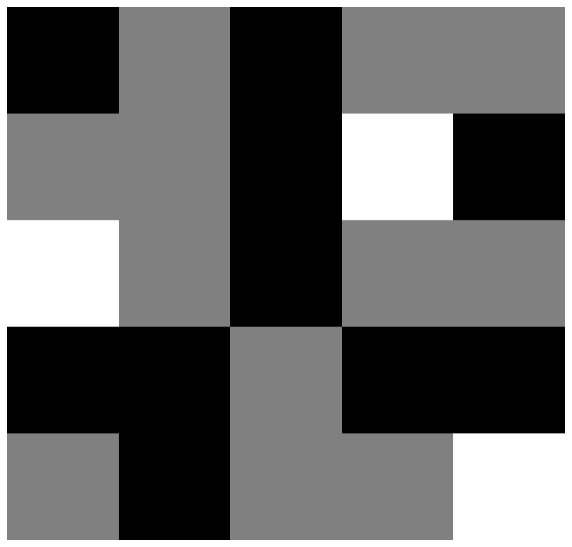

In [43]:
manager.logger.plotFigure(manager.mask_tr_val, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))


In [44]:

train_unique = get_pixel_count_set(manager.label_mask, manager.mask_tr_val, 1)
val_unique = get_pixel_count_set(manager.label_mask, manager.mask_tr_val, 2)
test_unique = get_pixel_count_set(manager.label_mask, manager.mask_tr_val, 0)

total_unique = np.unique(manager.label_mask, return_counts=True)

In [45]:
print("train unique", train_unique)
print("val unique", val_unique)
print("test unique", test_unique)

print("total unique", total_unique)


train unique (array([0, 1, 2], dtype=uint8), array([ 51670884,    190363, 122102945], dtype=int64))
val unique (array([0, 1, 2], dtype=uint8), array([10755724,    20775, 32714549], dtype=int64))
test unique (array([0, 1, 2], dtype=uint8), array([ 36581631,    295459, 108093070], dtype=int64))
total unique (array([0, 1, 2], dtype=uint8), array([ 99008239,    506597, 262910564], dtype=int64))


In [46]:
print("train unique percentage", np.round(train_unique[1]/np.sum(train_unique[1]), 4))
print("val unique", np.round(val_unique[1]/np.sum(val_unique[1]), 4))
print("test unique", np.round(test_unique[1]/np.sum(test_unique[1]), 4))

train unique percentage [0.297  0.0011 0.7019]
val unique [2.473e-01 5.000e-04 7.522e-01]
test unique [0.2523 0.002  0.7456]


In [47]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [48]:
if config["training"] == True:
    manager.extractCoords()

In [49]:
if config["training"] == True:
    manager.trainTestSplit()

In [50]:
if config["training"] == True:
    manager.label_mask.shape

In [51]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [52]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [53]:
if config["training"] == True:
    print(manager.coords_train)

In [54]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [55]:
if config["training"] == True:
    inputSnipShow = True

In [56]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [57]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [58]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [59]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [60]:
manager.dataset.bands

4

In [61]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [5, 6, 7]]

In [62]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [63]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [64]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

In [65]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [66]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [67]:
if config["training"] == True:
    manager.getGenerators()


In [68]:
if config["training"] == True:
    manager.fixChannelNumber()

In [69]:
if config["training"] == True:
    print(manager.path_exp)

In [70]:
if config["training"] == True:
    print(manager.channels)

In [71]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [72]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [73]:
manager.class_n

3

In [74]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

In [75]:
if config["training"] == True:
    manager.plotHistory()


In [76]:
repetition_id = 0

In [77]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [78]:
manager.image_stack.shape

(18605, 19480, 9)

In [79]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [80]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [81]:
manager.image_stack.shape

(18605, 19480, 9)

In [82]:
manager.setPadding()

-35.0 -8.0


In [83]:
import src.network as network
from tensorflow.keras.models import Model, load_model, Sequential
'''
def infer(self):

    self.h, self.w, self.c = self.image1_pad.shape
    self.c = self.channels
    patch_size_rows = self.h//self.n_rows
    patch_size_cols = self.w//self.n_cols
    num_patches_x = int(self.h/patch_size_rows)
    num_patches_y = int(self.w/patch_size_cols)

    ic(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5')
    model = load_model(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5', compile=False)
    
    if self.classes_mode == False:
        class_n = 3
        self.patchesHandler.class_n = class_n
    else:
        class_n = 2    
        self.patchesHandler.class_n = class_n + 1
    if self.config["loadInference"] == False:
        if self.config["save_probabilities"] == False:
            if self.classes_mode == False:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)
            else:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)

            # self.prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)
        print("Dropout training mode: {}".format(self.config['dropout_training']))
        new_model = network.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, self.c), 
            nb_filters = self.nb_filters, n_classes = class_n, dropout_seed = None, training=self.config['dropout_training'])

        for l in range(1, len(model.layers)):
            new_model.layers[l].set_weights(model.layers[l].get_weights())
        
        

        metrics_all =[]
        with tf.device('/cpu:0'):
            for tm in range(0,self.config["inference_times"]):

                print('time: ', tm)

                
                # Recinstructing predicted map
                start_test = time.time()
                
                prob_reconstructed = self.patchesHandler.infer(
                        new_model, self.image1_pad, self.h, self.w, 
                        num_patches_x, num_patches_y, patch_size_rows, 
                        patch_size_cols, classes_mode = self.classes_mode)
                        
                ts_time =  time.time() - start_test

                if self.config["save_probabilities"] == True:
                    np.save(self.path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
                else:
                    self.prob_rec[...,tm] = prob_reconstructed
                
                metrics_all.append(ts_time)
                del prob_reconstructed
            metrics_ = np.asarray(metrics_all)
            # Saving test time
            np.save(self.path_exp+'/metrics_ts.npy', metrics_)
    del self.image1_pad
'''

'\ndef infer(self):\n\n    self.h, self.w, self.c = self.image1_pad.shape\n    self.c = self.channels\n    patch_size_rows = self.h//self.n_rows\n    patch_size_cols = self.w//self.n_cols\n    num_patches_x = int(self.h/patch_size_rows)\n    num_patches_y = int(self.w/patch_size_cols)\n\n    ic(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\')\n    model = load_model(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\', compile=False)\n    \n    if self.classes_mode == False:\n        class_n = 3\n        self.patchesHandler.class_n = class_n\n    else:\n        class_n = 2    \n        self.patchesHandler.class_n = class_n + 1\n    if self.config["loadInference"] == False:\n        if self.config["save_probabilities"] == False:\n            if self.classes_mode == False:\n                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)\n            else:

In [84]:
'''
import types

manager.infer = types.MethodType(infer, manager)
'''


'\nimport types\n\nmanager.infer = types.MethodType(infer, manager)\n'

In [85]:
manager.infer()

time:  0
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_0.h5
runtime_repetition 130.47
time:  1
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_1.h5
runtime_repetition 139.02
time:  2
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_2.h5
runtime_repetition 137.83
time:  3
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_3.h5
runtime_repetition 135.93
time:  4
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_4.h5
runtime_repetition 135.72
time:  5
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_5.h5
runtime_repetition 134.4
time:  6
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_6.h5
runtime_repetition 139.84
time:  7
Loading model in: D:/Jorge/datasets/deforestation/experiments/MS/exp37/models/resunet_7.h5
runtime_repetition 

In [86]:
manager.loadPredictedProbabilities()

In [87]:
manager.prob_rec.shape

(18640, 19488, 10)

In [88]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [89]:
manager.prob_rec.shape

(18640, 19488, 10)

In [90]:
manager.getMeanProb()

In [91]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:121 in getStats()
    np.min(value): 1.0435144e-10
    np.mean(value): 0.0027116935
    np.max(value): 1.0


In [92]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <cell line: 1>()
    manager.mean_prob.shape: (18640, 19488)


(18640, 19488)

In [93]:
manager.unpadMeanProb()

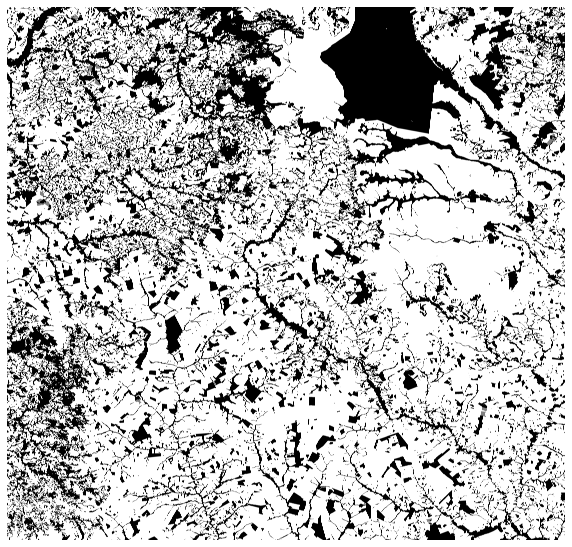

In [94]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [95]:
manager.squeezeLabel()

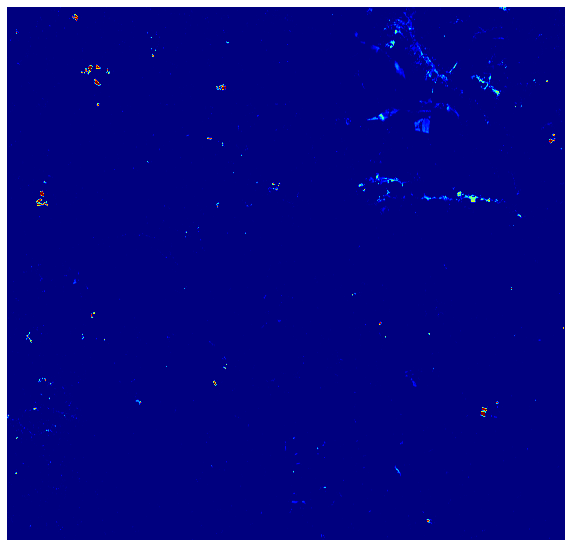

In [96]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [97]:
print(manager.label_mask.shape)

(18605, 19480)


In [98]:
# manager.getLabelTest()

In [99]:
# manager.getMAP()

In [100]:
manager.prob_rec.shape

(18640, 19488, 10)

In [101]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(10, 18640, 19488, 1)


In [102]:
manager.prob_rec.shape

(10, 18640, 19488, 1)

In [103]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0027084297
    np.max(value): 1.0


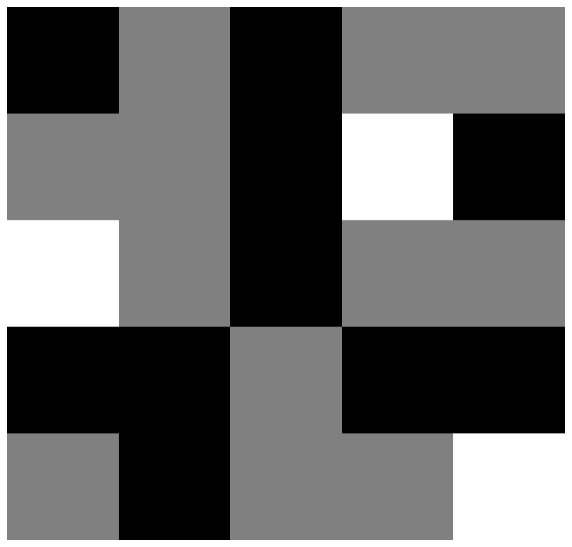

In [104]:
manager.logger.plotFigure(manager.mask_tr_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [105]:
manager.getLabelCurrentDeforestation()

In [106]:
manager.applyProbabilityThreshold()

(18605, 19480)
(array([0., 1.], dtype=float32), array([361935478,    489922], dtype=int64))


ic| base.py:413 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (18605, 19480)
    self.predicted.shape: (18605, 19480)


In [107]:
manager.getTestValues()

ic| base.py:436 in getTestValues()- predicted_test.shape: (144970160,)
ic| base.py:445 in getTestValues()- predicted_test.shape: (36877090,)


In [108]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([361935478,    489922], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([361965905,    459495], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([362394973,     30427], dtype=int64))


In [109]:
manager.calculateMetrics()

ic| base.py:489 in calculateMetrics()
    self.f1: 80.37
    self.precision: 81.91
    self.recall: 78.88


In [110]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:418 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (43491048,)
ic| base.py:424 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (10772344,)
ic| base.py:500 in calculateMetricsValidation()
    f1_val: 44.82
    precision_val: 45.53
    recall_val: 44.13
    mAP_val: 45.45


In [111]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [112]:
manager.get_label_no_buffer()

D:/Jorge/datasets/deforestation/MS/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:638 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:641 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:645 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MS/deforestation_before_2000_MS.tif


ic| dataset.py:649 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 208], dtype=uint8), array([126708038, 235735967], dtype=int64))
ic| dataset.py:651 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([334024764,   8717093,   6541094,   3824922,   2096535,   1305948,
                                                                      1003721,    903906,    318788,    701575,    310887,    440417,
                                                                       316180,    560438,    600838,    776899], dtype=int64))
ic| dataset.py:630 in loadLabel()
    label_per_date.shape: (18605, 19481, 1)


In [113]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([362209240,    216160], dtype=int64))


In [114]:
manager.getErrorMaskToShowRGB()

[0. 1.]


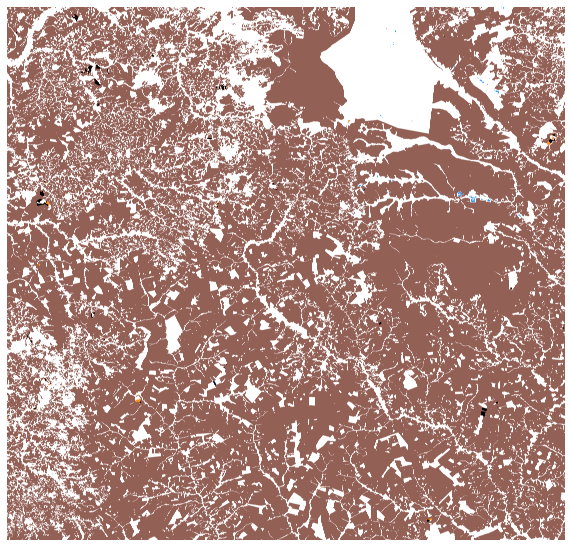

In [115]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [116]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [117]:
manager.config['uncertainty_method']

'pred_entropy'

In [118]:
manager.config['uncertainty_method'] = "pred_entropy"

In [119]:
print(np.min(manager.prob_rec), np.mean(manager.prob_rec), np.max(manager.prob_rec))
print(np.std(manager.prob_rec))
print(manager.prob_rec.shape)

0.0 0.0027084297 1.0
0.042532276
(10, 18640, 19488, 1)


In [120]:
manager.setUncertainty()

pred_mean 1.0435144e-10 0.0027116935 1.0
K = 1, pred_mean shape (18640, 19488, 1)


In [121]:
# manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [122]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:121 in getStats()
    np.min(value): -0.0
    np.mean(value): 0.0033104706
    np.max(value): 0.36787948


In [123]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0030321095
    np.max(value): 0.36787948


ic| 3944692317.py:4 in <cell line: 4>()
    manager.uncertainty_to_show.shape: (18605, 19480)


(18605, 19480)

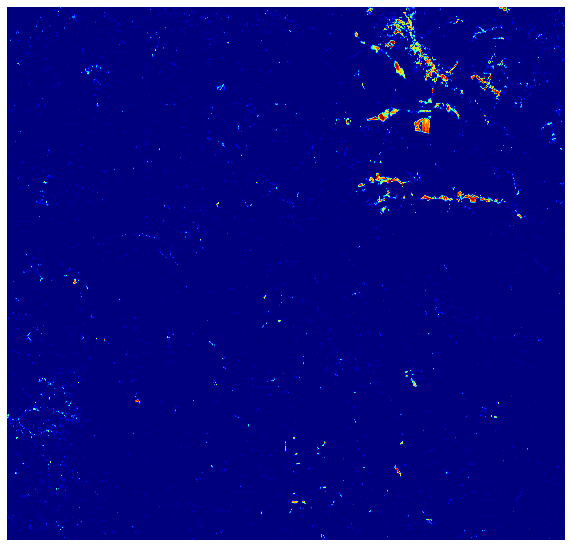

In [124]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



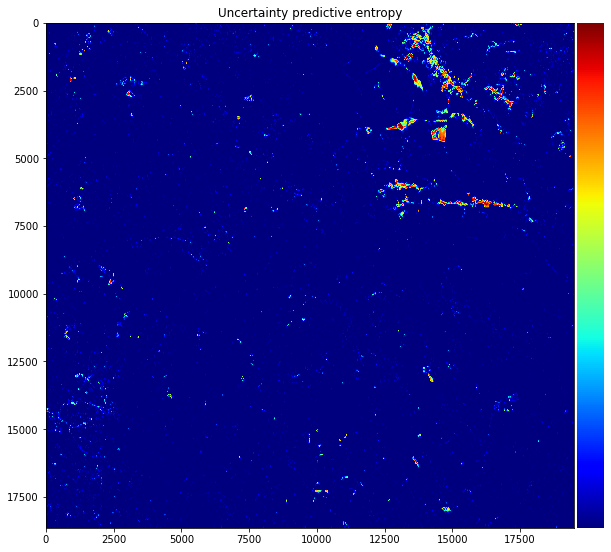

In [125]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

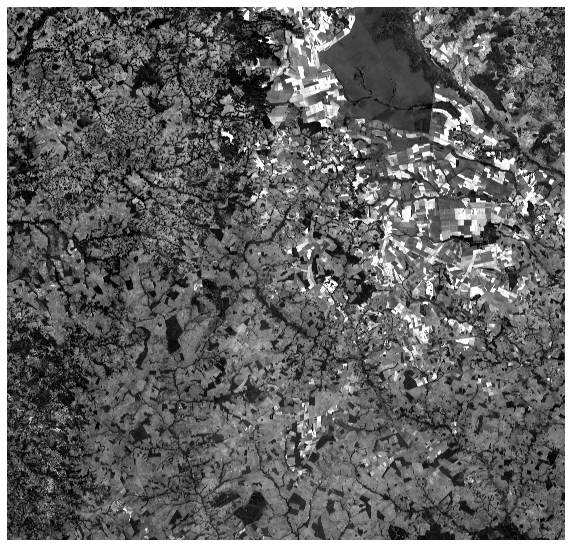

In [126]:

manager.logger.plotFigure(manager.image_stack[...,7], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [127]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:540 in getTestValues2()
    self.label_mask.shape: (18605, 19480)
ic| base.py:541 in getTestValues2()
    self.mask_amazon_ts.shape: (18605, 19480)
ic| base.py:545 in getTestValues2()
    self.label_mask_test.shape: (144970160,)
ic| base.py:553 in getTestValues2()
    self.error_mask_test.shape: (36862878,)


In [128]:
manager.dataset.previewLims1 = np.array([ 5500,  8500, 10000, 12500])

ic| Logger.py:165 in plotCropSample()
    manager.dataset.previewLims1: array([ 5500,  8500, 10000, 12500])
    manager.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| Logger.py:167 in plotCropSample()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([0, 1], dtype=uint8)
ic| Logger.py:169 in plotCropSample()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


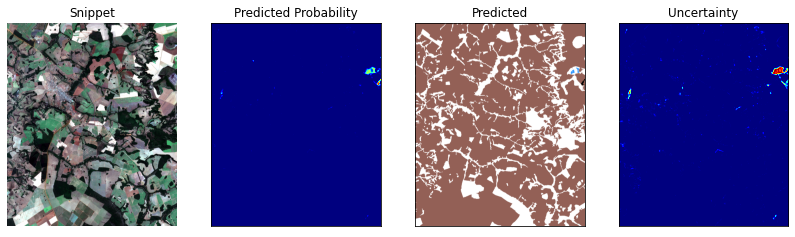

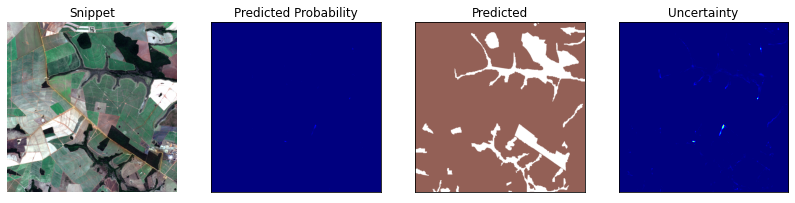

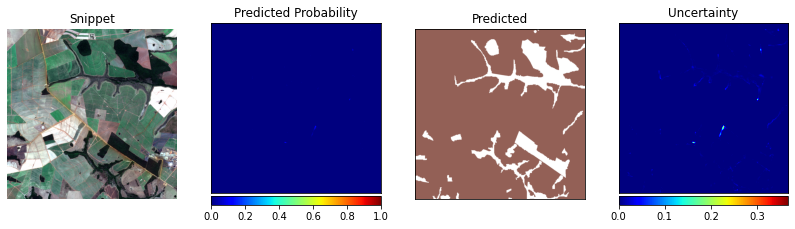

In [129]:
manager.logger.plotCropSample(manager)

In [130]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [131]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [132]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

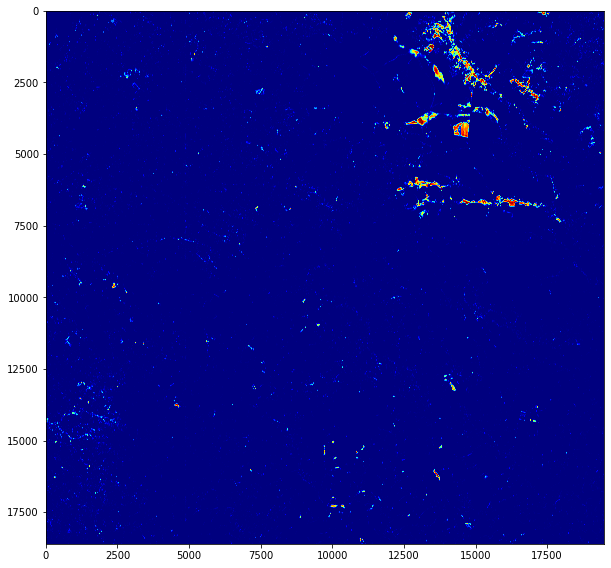

In [133]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.uncertainty_to_show, cmap = 'jet')


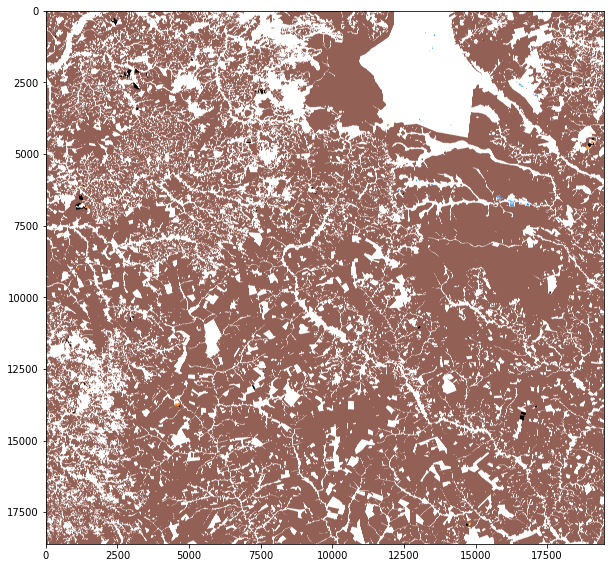

In [134]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.error_mask_to_show_rgb[...,::-1])


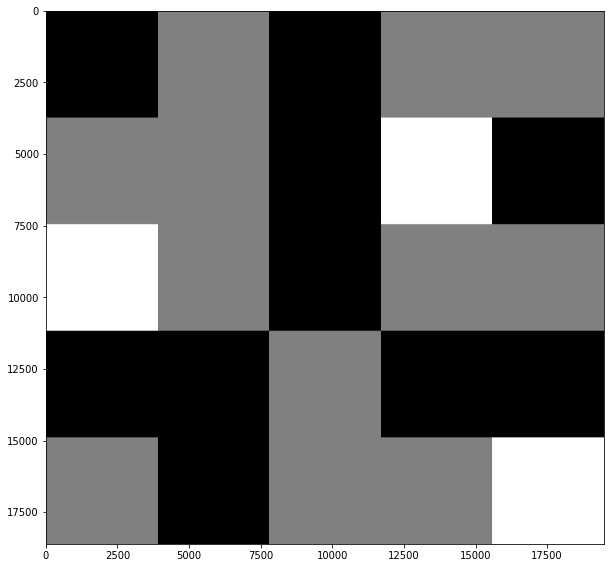

In [135]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.mask_tr_val, cmap='gray')

In [136]:
manager.dataset.previewLims1 = np.array([230, 500, 2230, 2500])
manager.dataset.previewLims2 = np.array([12500, 15000, 15000, 17500])
manager.dataset.previewLims2 = np.array([4000, 5000, 18000, None])
manager.dataset.previewLims2 = np.array([3000, 7000, 16000, None])


# PI
manager.dataset.previewLims2 = np.array([5000, 7500, 12500, 15000])
manager.dataset.previewLims1 = np.array([17000, 18000, 5000, 7500])
manager.dataset.previewLims2 = np.array([5000, 7500, 10000, 12500])

# MA

manager.dataset.previewLims1 = np.array([17000, 18000, 6000, 7000])
manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])

# MS

manager.dataset.previewLims1 = np.array([15000, 17500, 5000, 7700])
manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])


In [137]:
manager.dataset.previewLims1 = np.array([15000, 17500, 12500, 15000])
# manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])


In [138]:
lims = manager.dataset.previewLims1
ic(np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
lims = manager.dataset.previewLims2
ic(np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))


ic| 2731197965.py:2 in <cell line: 2>()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| 2731197965.py:4 in <cell line: 4>()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([ 116000, 2384000], dtype=int64))


(array([0, 1], dtype=uint8), array([ 116000, 2384000], dtype=int64))

ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([0, 1], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([ 116000, 2384000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([0, 1], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([ 116000, 2384000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_amazon_ts[lims[0]:l

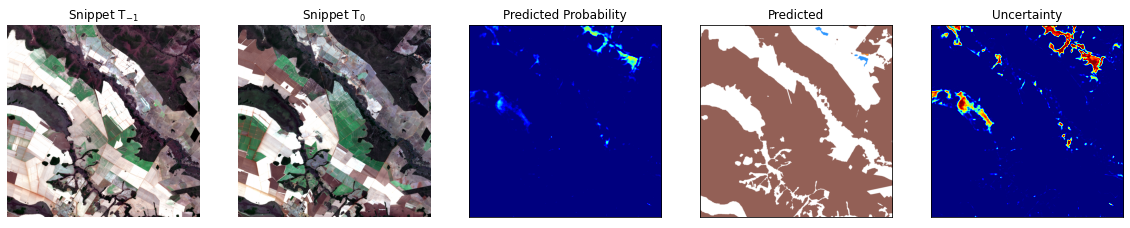

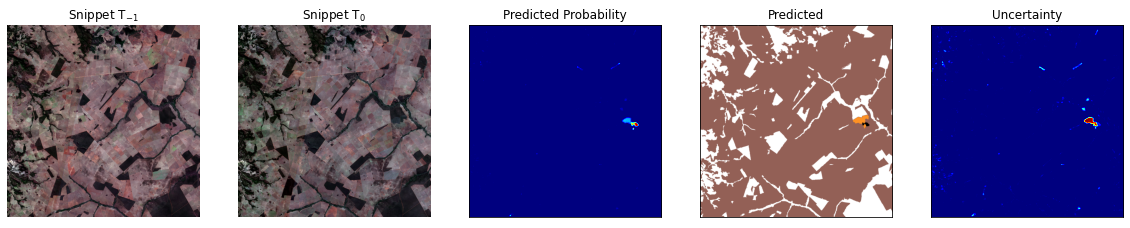

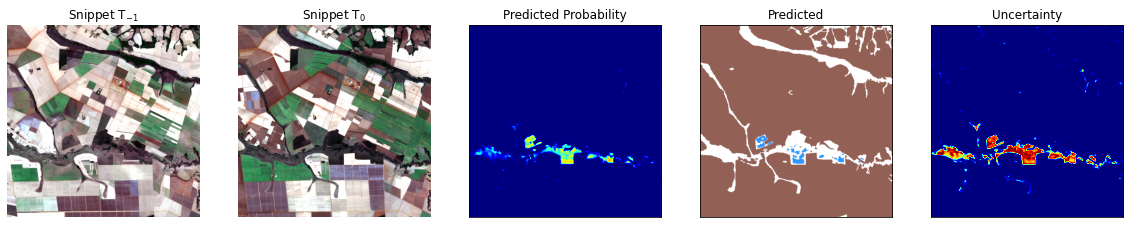

In [162]:
manager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
manager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])
manager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')

# manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, colorbar=True, save_name='Colorbar')

In [140]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:121 in getStats()
    np.min(value): -0.0
    np.mean(value): 0.0065678763
    np.max(value): 0.36787948


In [141]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [142]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [143]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [144]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [145]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                # self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                #            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]                            
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
            self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19)
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [146]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [147]:

manager.getUncertaintyAAValues()

ic| 321378179.py:65 in getUncertaintyAAValues()
    self.uncertainty.shape: (36862878,)
    self.label_mask_current_deforestation_test.shape: (36862878,)


[0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.005


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3931187,)
    predicted_test_classified_incorrect.shape: (3931187,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3931187
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3931187
    len(label_mask_current_deforestation_test): 36862878


[0.99596571 0.88361523 0.37706678 0.10664352 0.70453751 0.7182731
 0.02445306]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3147152,)
    predicted_test_classified_incorrect.shape: (3147152,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3147152
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3147152
    len(label_mask_current_deforestation_test): 36862878


[0.99543383 0.88574331 0.39865412 0.08537456 0.69357689 0.70951184
 0.03032258]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2681664,)
    predicted_test_classified_incorrect.shape: (2681664,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2681664
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2681664
    len(label_mask_current_deforestation_test): 36862878


[0.9950725  0.88648713 0.41474852 0.07274701 0.68483423 0.70297043
 0.0353445 ]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2129514,)
    predicted_test_classified_incorrect.shape: (2129514,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2129514
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2129514
    len(label_mask_current_deforestation_test): 36862878


[0.99454625 0.88806366 0.44021487 0.05776852 0.66988553 0.69128757
 0.04405582]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1586177,)
    predicted_test_classified_incorrect.shape: (1586177,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1586177
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1586177
    len(label_mask_current_deforestation_test): 36862878


[0.99381448 0.89006866 0.47410073 0.04302911 0.64760798 0.67344262
 0.0583022 ]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1052221,)
    predicted_test_classified_incorrect.shape: (1052221,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1052221
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1052221
    len(label_mask_current_deforestation_test): 36862878


[0.9919515  0.89271303 0.53100432 0.02854419 0.60278221 0.63632478
 0.08545832]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (786064,)
    predicted_test_classified_incorrect.shape: (786064,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 786064
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 786064
    len(label_mask_current_deforestation_test): 36862878


[0.99020078 0.89241557 0.57920439 0.021324   0.55441463 0.59727444
 0.11072932]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (678640,)
    predicted_test_classified_incorrect.shape: (678640,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 678640
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 678640
    len(label_mask_current_deforestation_test): 36862878


[0.98935809 0.89086201 0.60533224 0.01840985 0.52249463 0.57251842
 0.12533978]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (505054,)
    predicted_test_classified_incorrect.shape: (505054,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 505054
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 505054
    len(label_mask_current_deforestation_test): 36862878


[0.98827105 0.88760107 0.65776805 0.01370088 0.44059706 0.50615269
 0.15990726]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (380960,)
    predicted_test_classified_incorrect.shape: (380960,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 380960
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 380960
    len(label_mask_current_deforestation_test): 36862878


[0.98747041 0.88263785 0.69930801 0.01033452 0.35126247 0.43100113
 0.19948339]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (332550,)
    predicted_test_classified_incorrect.shape: (332550,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 332550
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 332550
    len(label_mask_current_deforestation_test): 36862878


[0.98462894 0.8793932  0.71615051 0.00902127 0.30834448 0.3915258
 0.21883247]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (288719,)
    predicted_test_classified_incorrect.shape: (288719,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 288719
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 288719
    len(label_mask_current_deforestation_test): 36862878


[0.97530311 0.8754768  0.73132364 0.00783224 0.26973374 0.34924909
 0.23415921]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (252741,)
    predicted_test_classified_incorrect.shape: (252741,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 252741
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 252741
    len(label_mask_current_deforestation_test): 36862878


[0.95769138 0.87200777 0.74273206 0.00685625 0.24586227 0.31094498
 0.23943791]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (191328,)
    predicted_test_classified_incorrect.shape: (191328,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 191328
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 191328
    len(label_mask_current_deforestation_test): 36862878


[0.9113123  0.8662396  0.75962997 0.00519026 0.22551222 0.23725904
 0.22738206]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (116777,)
    predicted_test_classified_incorrect.shape: (116777,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 116777
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 116777
    len(label_mask_current_deforestation_test): 36862878


[0.83381332 0.85420439 0.78415427 0.00316788 0.20692826 0.05701495
 0.13713494]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (59788,)
    predicted_test_classified_incorrect.shape: (59788,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 59788
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 59788
    len(label_mask_current_deforestation_test): 36862878


[0.81910509 0.82180936 0.78882986 0.0016219         nan 0.
 0.07265807]
threshold 0.3648794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (35388,)
    predicted_test_classified_incorrect.shape: (35388,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 35388
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 35388
    len(label_mask_current_deforestation_test): 36862878


[0.81910509 0.80560409 0.78882986 0.00095999        nan 0.
 0.04274501]
threshold 0.3663794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (24771,)
    predicted_test_classified_incorrect.shape: (24771,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 24771
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 24771
    len(label_mask_current_deforestation_test): 36862878


[8.19105092e-01 8.00243135e-01 7.88829857e-01 6.71976833e-04
            nan 0.00000000e+00 3.12147053e-02]


In [148]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:682 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (36862878,)
    self.label_mask_current_deforestation_test.shape: (36862878,)


threshold 0.005
(36862878,) (36862878,)
cm_audited [[36573703      441]
 [   14340   274394]]
[0.9983954  0.95033491]
threshold 0.0075
(36862878,) (36862878,)
cm_audited [[36573616      528]
 [   14848   273886]]
[0.9980759  0.94857551]
threshold 0.01
(36862878,) (36862878,)
cm_audited [[36573551      593]
 [   15334   273400]]
[0.99783571 0.9468923 ]
threshold 0.015
(36862878,) (36862878,)
cm_audited [[36573447      697]
 [   16021   272713]]
[0.99745072 0.94451294]
threshold 0.025
(36862878,) (36862878,)
cm_audited [[36573292      852]
 [   16907   271827]]
[0.99687545 0.94144437]
threshold 0.05
(36862878,) (36862878,)
cm_audited [[36572900     1244]
 [   18426   270308]]
[0.99541893 0.93618348]
threshold 0.08
(36862878,) (36862878,)
cm_audited [[36572489     1655]
 [   20161   268573]]
[0.99387554 0.93017449]
threshold 0.1
(36862878,) (36862878,)
cm_audited [[36572264     1880]
 [   21412   267322]]
[0.9930164  0.92584178]
threshold 0.15
(36862878,) (36862878,)
cm_audited [[36571890

ic| base.py:688 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[0.9983954 , 0.95033491],
                                  [0.9980759 , 0.94857551],
                                  [0.99783571, 0.9468923 ],
                                  [0.99745072, 0.94451294],
                                  [0.99687545, 0.94144437],
                                  [0.99541893, 0.93618348],
                                  [0.99387554, 0.93017449],
                                  [0.9930164 , 0.92584178],
                                  [0.99155609, 0.91670534],
                                  [0.99031189, 0.90701476],
                                  [0.98775431, 0.90178157],
                                  [0.97974982, 0.89598038],
                                  [0.96448107, 0.8909827 ],
                                  [0.92272212, 0.88270173],
                                  [0.84714243, 0.86616055],
                                  [0.82634154, 0.

cm_audited [[36523844    50300]
 [   56854   231880]]
[0.82174499 0.80309212]


In [149]:
manager.setPlotLimsForUncertaintyAA()

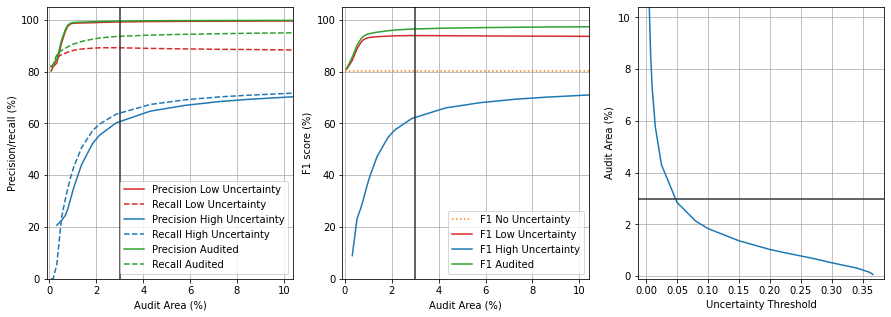

In [150]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [151]:
from scipy import optimize  


In [152]:
manager.getOptimalUncertaintyThreshold(bounds=(np.min(manager.uncertainty) + 0.000015, np.max(manager.uncertainty) - 0.0015))

ic| base.py:791 in getOptimalUncertaintyThreshold()
    bounds: (1.5e-05, 0.3663794801235199)


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.13995377913649928
threshold 0.13995377913649928


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (533370,)
    predicted_test_classified_incorrect.shape: (533370,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 533370
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 533370
    len(label_mask_current_deforestation_test): 36862878


[0.98843494 0.88827065 0.64855195 0.01446903 0.45708256 0.51979569
 0.15296853]
0.22644070098702052
threshold 0.22644070098702052


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (329855,)
    predicted_test_classified_incorrect.shape: (329855,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 329855
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 329855
    len(label_mask_current_deforestation_test): 36862878


[0.98434573 0.87922703 0.71714796 0.00894816 0.30569833 0.38885131
 0.21996123]
0.08650192185052122
threshold 0.08650192185052122


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (747164,)
    predicted_test_classified_incorrect.shape: (747164,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 747164
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 747164
    len(label_mask_current_deforestation_test): 36862878


[0.9899547  0.89189572 0.58808453 0.02026874 0.5440449  0.5893262
 0.11562274]
0.053466857285978074
threshold 0.053466857285978074


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1010266,)
    predicted_test_classified_incorrect.shape: (1010266,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1010266
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1010266
    len(label_mask_current_deforestation_test): 36862878


[0.99172355 0.8929227  0.53742545 0.02740605 0.59697847 0.63146677
 0.08869321]
0.033050064564543166
threshold 0.033050064564543166


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1347251,)
    predicted_test_classified_incorrect.shape: (1347251,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1347251
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1347251
    len(label_mask_current_deforestation_test): 36862878


[0.99331257 0.89137446 0.49488457 0.03654763 0.63238209 0.66083734
 0.06802521]
0.05589069223908553
threshold 0.05589069223908553


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (983307,)
    predicted_test_classified_incorrect.shape: (983307,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 983307
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 983307
    len(label_mask_current_deforestation_test): 36862878


[0.99159797 0.89309235 0.54199713 0.02667472 0.5927081  0.62787645
 0.09090701]
0.04772282635204282
threshold 0.04772282635204282


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1082186,)
    predicted_test_classified_incorrect.shape: (1082186,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1082186
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1082186
    len(label_mask_current_deforestation_test): 36862878


[0.99211541 0.89262852 0.52687941 0.02935707 0.60640609 0.63930283
 0.08329355]
0.04211833005804862
threshold 0.04211833005804862


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1166730,)
    predicted_test_classified_incorrect.shape: (1166730,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1166730
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1166730
    len(label_mask_current_deforestation_test): 36862878


[0.99258429 0.89218604 0.51502767 0.03165054 0.61644509 0.64769208
 0.0777451 ]
0.046884502828052226
threshold 0.046884502828052226


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1093780,)
    predicted_test_classified_incorrect.shape: (1093780,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1093780
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1093780
    len(label_mask_current_deforestation_test): 36862878


[0.99218019 0.89252939 0.52512693 0.02967158 0.60792846 0.64061251
 0.08248056]
0.04569260706844856
threshold 0.04569260706844856


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1110884,)
    predicted_test_classified_incorrect.shape: (1110884,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1110884
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1110884
    len(label_mask_current_deforestation_test): 36862878


[0.99228736 0.8924337  0.52267831 0.03013557 0.6100227  0.64237768
 0.08131762]
0.045518856619087944
threshold 0.045518856619087944


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1113379,)
    predicted_test_classified_incorrect.shape: (1113379,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1113379
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1113379
    len(label_mask_current_deforestation_test): 36862878


[0.99231437 0.89242113 0.52229388 0.03020326 0.61034182 0.64265017
 0.08115378]
0.04608817566291887
threshold 0.04608817566291887


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1105186,)
    predicted_test_classified_incorrect.shape: (1105186,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105186
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105186
    len(label_mask_current_deforestation_test): 36862878


[0.99228063 0.89245211 0.52355455 0.029981   0.60925245 0.64176491
 0.0817008 ]
0.04639234557383496
threshold 0.04639234557383496


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1100755,)
    predicted_test_classified_incorrect.shape: (1100755,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1100755
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1100755
    len(label_mask_current_deforestation_test): 36862878


[0.99226382 0.89248333 0.52418489 0.0298608  0.60870535 0.64130389
 0.08200466]
0.04603984805029685
threshold 0.04603984805029685


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1105855,)
    predicted_test_classified_incorrect.shape: (1105855,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105855
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105855
    len(label_mask_current_deforestation_test): 36862878


[0.99227931 0.89244086 0.5234645  0.02999915 0.60933325 0.64183756
 0.08165318]
0.04596673320865873
threshold 0.04596673320865873


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1106923,)
    predicted_test_classified_incorrect.shape: (1106923,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1106923
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1106923
    len(label_mask_current_deforestation_test): 36862878


[0.99229021 0.89243    0.52331904 0.03002812 0.609454   0.6419474
 0.08158056]
0.046006514034082215
threshold 0.046006514034082215


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1106362,)
    predicted_test_classified_incorrect.shape: (1106362,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1106362
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1106362
    len(label_mask_current_deforestation_test): 36862878
ic| base.py:795 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.04603984805029685


[0.99228481 0.89242816 0.52339524 0.0300129  0.60939053 0.64189755
 0.08161737]


In [153]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold:  0.04603984805029685
threshold 0.04603984805029685


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1105855,)
    predicted_test_classified_incorrect.shape: (1105855,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105855
    len(label_mask_current_deforestation_test): 36862878
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1105855
    len(label_mask_current_deforestation_test): 36862878


[0.99227931 0.89244086 0.5234645  0.02999915 0.60933325 0.64183756
 0.08165318]
threshold 0.04603984805029685
(36862878,) (36862878,)


ic| base.py:826 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.02999915]),
                     'UEO': array([0.08165318]),
                     'f1': 80.37,
                     'f1_H': array([0.62516319]),
                     'f1_L': array([0.93971574]),
                     'precision_H': array([0.60933325]),
                     'precision_L': array([0.99227931]),
                     'recall_H': array([0.64183756]),
                     'recall_L': array([0.89244086]),
                     'recall_Ltotal': array([0.5234645])}
ic| base.py:827 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.96539787]),
                             'precision': array([0.9956716]),
                             'recall': array([0.93691079])}


cm_audited [[36572968     1176]
 [   18216   270518]]
[0.9956716  0.93691079]


{'metrics': {'precision_L': array([0.99227931]),
  'recall_L': array([0.89244086]),
  'recall_Ltotal': array([0.5234645]),
  'AA': array([0.02999915]),
  'precision_H': array([0.60933325]),
  'recall_H': array([0.64183756]),
  'UEO': array([0.08165318]),
  'f1_L': array([0.93971574]),
  'f1_H': array([0.62516319]),
  'f1': 80.37},
 'metrics_audited': {'precision': array([0.9956716]),
  'recall': array([0.93691079]),
  'f1': array([0.96539787])},
 'exp': 37}

In [154]:
manager.dataset.paths.im_filenames[2019][0]
manager.dataset.paths.optical_im_past_dates[2019]

'D:/Jorge/datasets/sentinel2/MS/2019'

In [155]:
import utils_v1
import rasterio
georreferenced_save = True
if georreferenced_save == True:
    # georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')
    original_im_path = os.path.join(manager.dataset.paths.optical_im_past_dates[2019], 
        manager.dataset.paths.im_filenames[2019][0])
    print("path",original_im_path)
    georref_im = utils_v1.load_tiff_image(original_im_path)

    print("georref_im.shape", georref_im.shape)

    del georref_im

path D:/Jorge/datasets/sentinel2/MS/2019\S2_MS_B4_B3_2019_crop.tif
D:/Jorge/datasets/sentinel2/MS/2019\S2_MS_B4_B3_2019_crop.tif
georref_im.shape (2, 18605, 19481)


In [156]:
def save_georreferenced(im, original_im_path, produced_im_path, bands = 1, plot = False):
    if len(im.shape) == 2:
        pad_values = ((0, 0), (0, 1))
    else:
        pad_values = ((0, 0), (0, 1), (0, 0))
    im_pad = np.pad(im, pad_values)
    print("im_pad.shape", im_pad.shape)

    if plot == True:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im_pad, cmap='jet')
        plt.axis('off')

    if len(im_pad.shape) == 2:
        im_pad = np.expand_dims(im_pad, axis=0)
    else:
        im_pad = np.transpose(im_pad, (2, 0, 1))
    print("im_pad.shape", im_pad.shape)

    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_pad.astype(np.float32), produced_im_path, bands = bands,
                    nodata=-1)
    del im_pad

In [157]:
if georreferenced_save == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced.tif'.format(
        manager.dataset.site)
    save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)


im_pad.shape (18605, 19481)
im_pad.shape (1, 18605, 19481)


In [158]:
if georreferenced_save == True:
    predicted_to_show = manager.predicted_unpad.copy()
    predicted_to_show[manager.label_mask == 2] = 0

    false_positive_mask = predicted_to_show - manager.label_mask_current_deforestation
    false_positive_mask = (false_positive_mask + 1).astype(np.int8)
    del predicted_to_show
    ic(np.unique(false_positive_mask, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_false_positive_mask_georreferenced.tif'.format(
        manager.dataset.site)
    save_georreferenced(false_positive_mask, original_im_path,produced_im_path)

    del false_positive_mask


ic| 629664193.py:8 in <cell line: 1>()
    np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   131631, 362209240,     84529], dtype=int64))


im_pad.shape (18605, 19481)
im_pad.shape (1, 18605, 19481)


In [159]:
if georreferenced_save == True:

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_2019_rgb_georreferenced.tif'.format(
        manager.dataset.site)

    bands = manager.dataset.previewBandsSnip[0]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_2020_rgb_georreferenced.tif'.format(
        manager.dataset.site)
        
    bands = manager.dataset.previewBandsSnip[1]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)


im_pad.shape (18605, 19481, 3)
im_pad.shape (3, 18605, 19481)
im_pad.shape (18605, 19481, 3)
im_pad.shape (3, 18605, 19481)
